# More on Classification

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.svm as svm
import sklearn.model_selection as cross_validation # Code for cross validation.
import sklearn.cluster as cluster
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from patsy import dmatrices

import seaborn as sns

from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print('')

In [2]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

## Clustering vs. Classification

While the notions of clustering and classification are not always consistently defined across different communities (both academic and practicing), there are some widely agreed-upon ways in which we can distinguish between these two categories.

Clustering can be associated with:

* unlabeled data and **unsupervised** (machine) learning
* absence of a distinct "training set" (all the data is used for clustering)
* emphasizes the discovery of similarities between data set entries
* algorithms that run in a single overall stage to produce a result

Classification can be associated with:

* labeled data and **supervised** (machine) learning
* a distinction between (labeled) training data and (unlabeled) data to be classified
* a distinction between a training stage and an evaluation/utilization stage
* a large variety of different kinds of techniques and algorithms

## Support Vector Machines (SVMs)

For the examples in this section, we will work with the wine dataset available at https://archive.ics.uci.edu/ml/datasets/Wine.

In [3]:
import requests
data = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data').text
open('wine.data', 'w').write(data)
wine = pd.read_table("wine.data", sep=',')

attributes = [
    'region',
    'Alcohol',
    'Malic acid',
    'Ash',
    'Alcalinity of ash',
    'Magnesium',
    'Total phenols',
    'Flavanoids',
    'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity',
    'Hue',
    'OD280/OD315 of diluted wines',
    'Proline'
    ]

wine.columns = attributes
# Take two attributes and use a two-dimensional training dataset.
X = wine[['Alcohol', 'Malic acid',]].values
grape = wine.pop('region')
y = grape.values
wine.info()
wine

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 13 columns):
Alcohol                         177 non-null float64
Malic acid                      177 non-null float64
Ash                             177 non-null float64
Alcalinity of ash               177 non-null float64
Magnesium                       177 non-null int64
Total phenols                   177 non-null float64
Flavanoids                      177 non-null float64
Nonflavanoid phenols            177 non-null float64
Proanthocyanins                 177 non-null float64
Color intensity                 177 non-null float64
Hue                             177 non-null float64
OD280/OD315 of diluted wines    177 non-null float64
Proline                         177 non-null int64
dtypes: float64(11), int64(2)
memory usage: 18.1 KB


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.380000,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.680000,1.03,3.17,1185
2,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.800000,0.86,3.45,1480
3,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.320000,1.04,2.93,735
4,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.750000,1.05,2.85,1450
5,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.250000,1.02,3.58,1290
6,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.050000,1.06,3.58,1295
7,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.200000,1.08,2.85,1045
8,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.220000,1.01,3.55,1045
9,14.10,2.16,2.30,18.0,105,2.95,3.32,0.22,2.38,5.750000,1.25,3.17,1510


In [4]:
wine.head()
print(X.shape)

(X, y) = utils.shuffle(X, y, random_state=1)
print(X.shape)
print(y.shape)
print(y)

train_set_size = 100
X_train = X[:train_set_size]  # Selects first 100 rows (examples) for a training set.
y_train = y[:train_set_size]
X_test = X[train_set_size:]   # Selects from row 100 until the last one for a testing set.
y_test = y[train_set_size:]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(177, 2)
(177, 2)
(177,)
[2 2 1 2 1 3 2 1 2 2 1 1 2 1 2 2 3 1 2 1 1 2 3 2 1 2 1 1 1 2 3 3 3 1 2 2 2
 3 2 1 1 2 2 1 1 1 2 1 1 2 2 2 3 1 2 2 1 2 3 2 2 1 3 3 2 1 2 1 2 1 3 3 3 3
 2 1 3 1 2 3 1 2 1 3 2 2 1 2 2 3 1 2 2 2 3 2 2 2 3 1 1 1 3 1 2 3 3 1 2 1 2
 2 1 3 2 3 3 3 2 2 2 3 3 2 1 2 1 3 2 2 1 1 2 1 1 1 3 1 3 3 1 2 2 3 1 2 2 1
 1 1 2 2 1 3 3 2 2 2 1 3 3 3 3 3 2 1 1 3 2 3 3 2 3 3 2 3 1]
(100, 2) (100,)
(77, 2) (77,)


We can use the [SVM library](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) provided by scikit-learn .

In [5]:
svc = svm.SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred_test = svc.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_test))

Accuracy of SVM test set: 0.7142857142857143


We can evaluate the fit of the classifier visually.

In [6]:
from matplotlib.colors import ListedColormap
# Create color maps for 3-class classification problem, as with iris
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_estimator(estimator, X, y):
    try:
        (X, y) = (X.values, y.values)
    except AttributeError:
        pass
    
    estimator.fit(X, y)
    (x_min, x_max) = X[:, 0].min() - .1, X[:, 0].max() + .1
    (y_min, y_max) = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot.
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points.
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.axis('tight')
    plt.axis('off')
    plt.tight_layout()

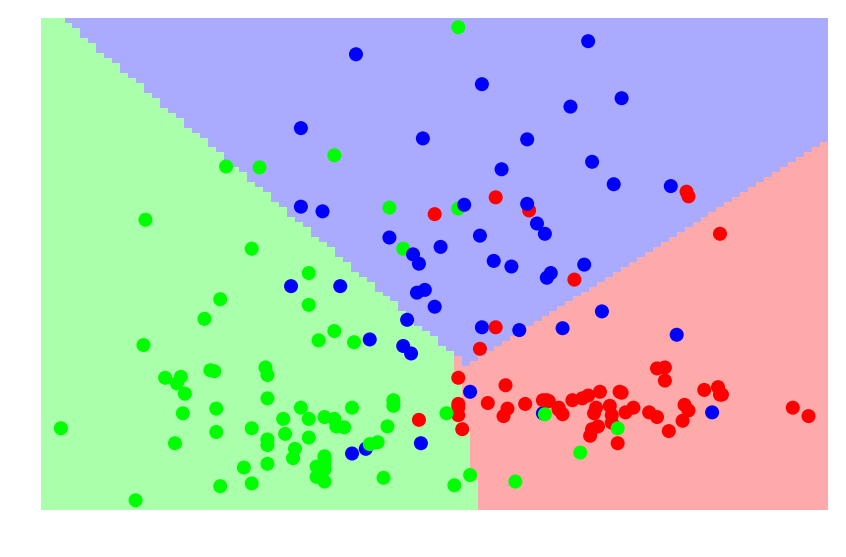

In [7]:
plot_estimator(svc, X, y)

The SVM gets its name from the samples in the dataset from each class that lie closest to the other class. These training samples are called "support vectors" because changing their position in p-dimensional space would change the location of the decision boundary.

In `scikit-learn`, the indices of the support vectors for each class can be found in the `support_vectors_` attribute of the SVC object. Here is a two-class problem using only classes 1 and 2 in the wine dataset. The support vectors are circled.

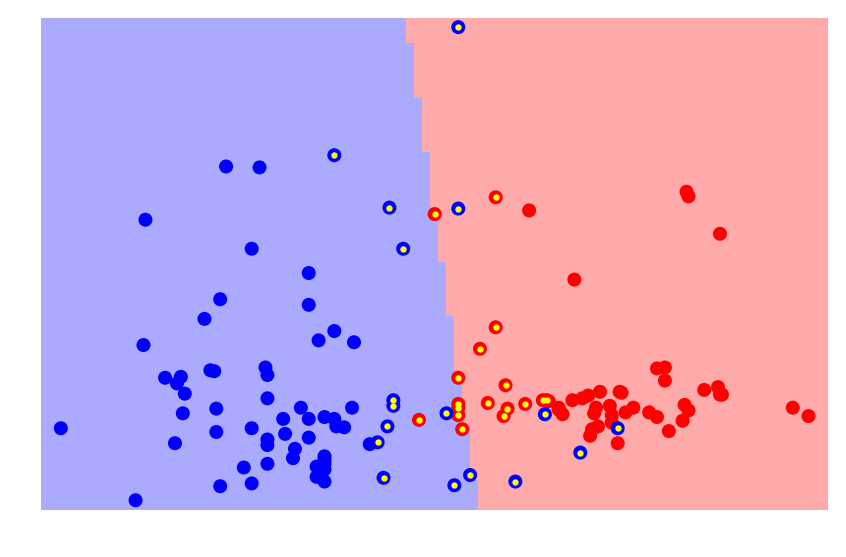

In [8]:
# Extract classes 1 and 2.
(X, y) = X[np.in1d(y, [1, 2])], y[np.in1d(y, [1, 2])]

plot_estimator(svc, X, y)
plt.scatter(svc.support_vectors_[:, 0], 
               svc.support_vectors_[:, 1], 
               s=10, 
                c = 'yellow',
               facecolors='none', 
               linewidths=0.02,
               zorder=10
           )

## Regularization

These two classes do not appear to be linearly separable. For non-linearly separable classes, we can employ __regularization__. Regularization is tuned via the C parameter. In practice, a large C value means that the number of support vectors is small (less regularization), while a small C implies that many support vectors exist (more regularization). The `scikit-learn` library sets a default value of C=1.

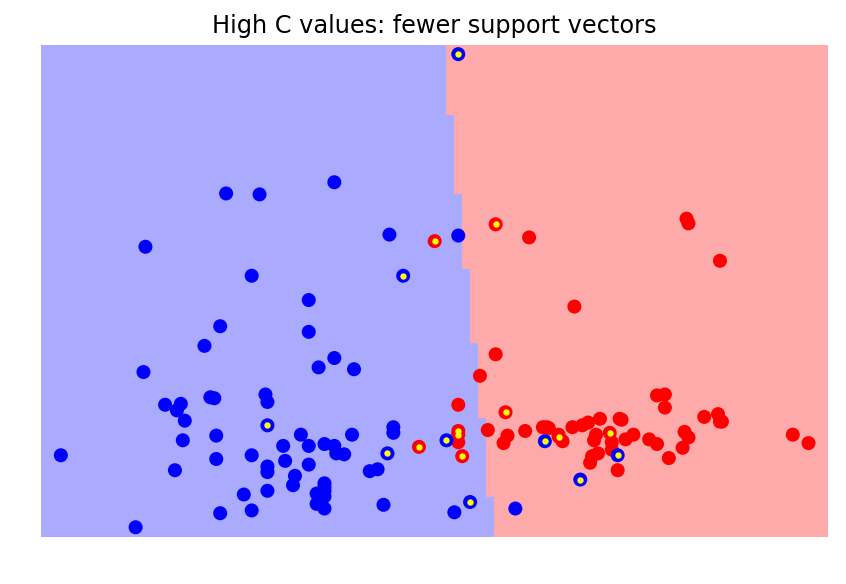

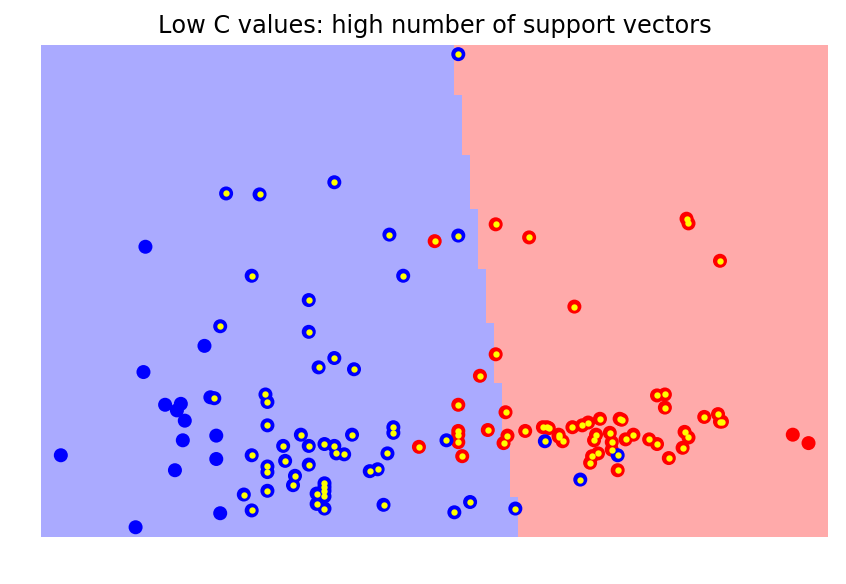

In [9]:
svc = svm.SVC(kernel='linear', C=1e6)
plot_estimator(svc, X, y)
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], 
                                       s=10, 
                c = 'yellow',
               facecolors='none', 
               linewidths=0.02,
               zorder=10)
plt.title('High C values: fewer support vectors')

svc = svm.SVC(kernel='linear', C=1e-2)
plot_estimator(svc, X, y)
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], 
                           s=10, 
                c = 'yellow',
               facecolors='none', 
               linewidths=0.02,
               zorder=10)
_ = plt.title('Low C values: high number of support vectors')

## Kernels

The scikit-learn library allows users to choose from a suite of available kernels:
* `'linear'` 
* `'poly'`
* `'rbf'`
* `'sigmoid'`
* `'precomputed'`

Furthermore, a custom kernel can be supplied as a function. Note that the radial basis function (`'rbf'`) kernel is just a Gaussian kernel, but with parameter $\gamma = \frac{1}{\sigma^2}$.

### Linear Kernel

Accuracy of SVM test set: 0.922077922077922


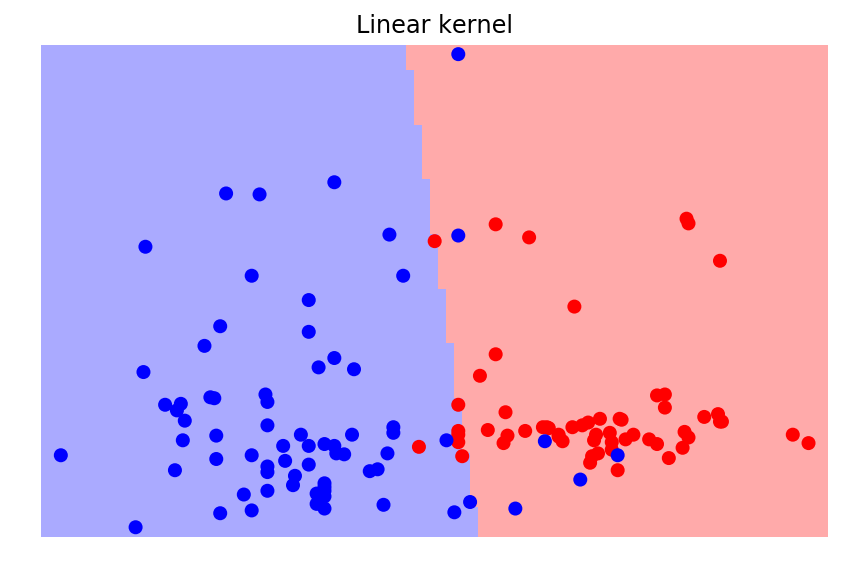

In [10]:
svc_lin = svm.SVC(kernel='linear')
plot_estimator(svc_lin, X, y)
plt.scatter(svc_lin.support_vectors_[:, 0], svc_lin.support_vectors_[:, 1], 
            s=80, facecolors='none', linewidths=2, zorder=10)
plt.title('Linear kernel')
y_pred_test = svc_lin.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_pred_test))

### Polynomial Kernel

Accuracy of SVM test set: 0.8311688311688312


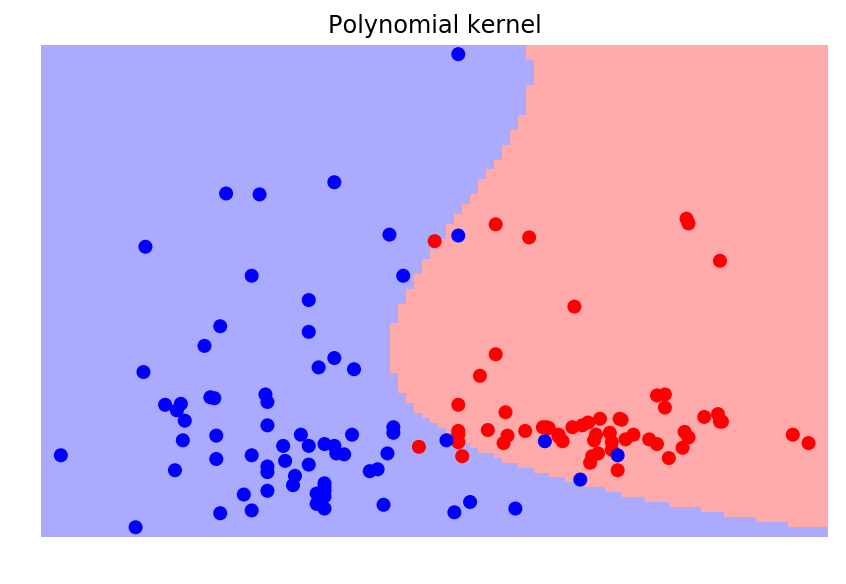

In [11]:
svc_poly = svm.SVC(kernel='poly', degree=3)
plot_estimator(svc_poly, X, y)
plt.scatter(svc_poly.support_vectors_[:, 0], svc_poly.support_vectors_[:, 1], 
           s=80, facecolors='none', linewidths=2, zorder=10)
plt.title('Polynomial kernel')
y_pred_test = svc_poly.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_pred_test))

### RBF Kernel

Accuracy of SVM test set: 0.987012987012987


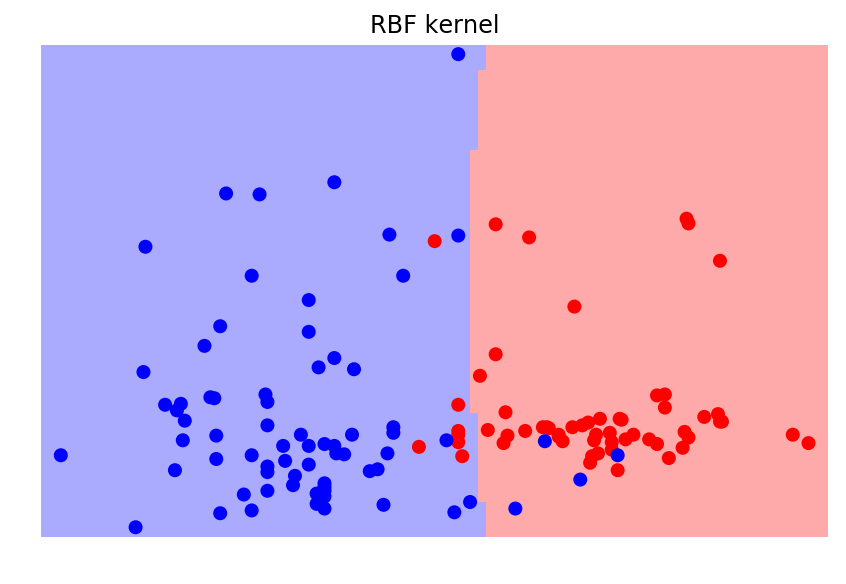

In [12]:
svc_rbf = svm.SVC(kernel='rbf', gamma=1e-2)
plot_estimator(svc_rbf, X, y)
plt.scatter(svc_rbf.support_vectors_[:, 0], svc_rbf.support_vectors_[:, 1], 
           s=80, facecolors='none', linewidths=2, zorder=10)
plt.title('RBF kernel')
y_pred_test = svc_rbf.predict(X_test)
print("Accuracy of SVM test set:", svc.score(X_test, y_pred_test))

## Cross-validation

So far we've been evaluating our classifiers by "holding out" some of the data as test data.  There is a problem with this, however: if we use the test data over and over, while varying model parameters, there is a new danger of overfitting.

One technique that helps with this (but does not avoid it completely) is to not use a fixed set of test data, but to sample the test data multiple times and look at: 

* the average behavior of the classifier, and
* how the test score varies across the different test subsets. 

Note that it is still possible to overfit, even with cross-validation, if you use the same data over and over. 

In [13]:
(X_train, X_test, y_train, y_test) = cross_validation.train_test_split(wine.values, grape.values, test_size=0.4)

In [14]:
f = svm.SVC(kernel='linear', C=1)
f.fit(X_train, y_train)
f.score(X_test, y_test)

0.9577464788732394

So far, this is fine -- but what if we want to vary C?  Now, we are in danger of overfitting if we use the same test data to find the "best" value of C.

In [15]:
# Mean accuracy.
scores = cross_validation.cross_val_score(f, wine.values, grape.values, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.86486486 0.97222222 0.94444444 1.         1.        ]
Accuracy: 0.96 (+/- 0.10)


## Analyzing the Iris dataset

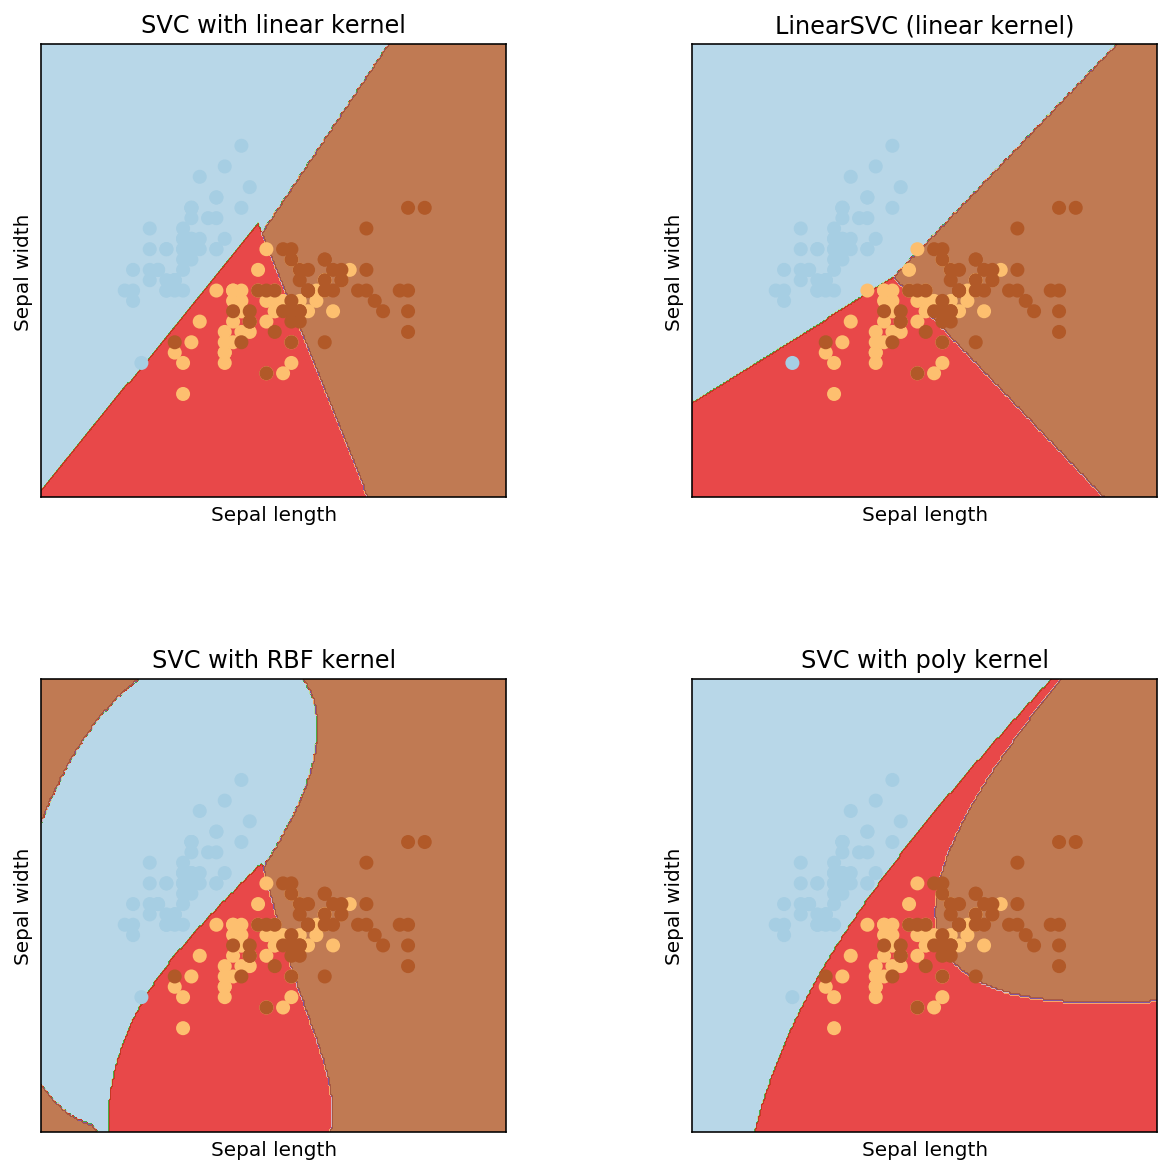

In [16]:
iris = datasets.load_iris()
X = iris.data[:, :2]  # We only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset.
y = iris.target

h = .02  # step size in the mesh

# We create an instance of an SVM and fit out data. We do not scale our
# data since we want to plot the support vectors.

C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# Create a mesh to plot in
(x_min, x_max) = X[:, 0].min() - 1, X[:, 0].max() + 1
(y_min, y_max) = X[:, 1].min() - 1, X[:, 1].max() + 1
(xx, yy) = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Title for the plots.
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel', 'SVC with poly kernel']

fig = plt.figure(figsize=(10,10))

for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot.
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # Plot also the training points.
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()